# Using machine learning to predict likelihood of an employee leaving

Using the data collected, we will use ML to identify patterns in employee data that will allow us to predict likely leavers before they actually resign.

We will use SciKitLearn to look for correlations in data for the Leavers v. Remainers, focusing in on those features of the data that most predict attrition.

This workbook will look at the prediction of attrition; the subsequent notebook 4. will then look to cluster leavers into similar groups, so that HR and the business can use those profiles to develop a retention strategy.

In [3]:
## Step 1 - Import necessary libraries
import pandas as pd
import sklearn
import joblib  # for saving an ml model

# Robust data-file finder and loader (uses a relative path for reading)
from pathlib import Path
import os


### Step 1 - import the cleaned data

In [4]:
# Load cleaned data using an explicit relative path
df = pd.read_csv('../Data files/HR_Attrition_Cleaned.csv')

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           1470 non-null   int64  
 1   Attrition                     1470 non-null   object 
 2   BusinessTravel                1470 non-null   object 
 3   DailyRate                     1470 non-null   int64  
 4   Department                    1470 non-null   object 
 5   DistanceFromHome              1470 non-null   int64  
 6   Education                     1470 non-null   object 
 7   EducationField                1470 non-null   object 
 8   EnvironmentSatisfaction       1470 non-null   object 
 9   Gender                        1470 non-null   object 
 10  HourlyRate                    1470 non-null   int64  
 11  JobInvolvement                1470 non-null   object 
 12  JobLevel                      1470 non-null   int64  
 13  Job

### Step 2 - Data preparation for ML

Next, as we're working with a mix of numeric and string columns, we'll identify the data types in readiness to encoding. But our target column (Attrition) needs to be removed.

In [5]:
target_col = "Attrition"

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

# Remove target from both lists if present
numeric_cols = [col for col in numeric_cols if col != target_col]
categorical_cols = [col for col in categorical_cols if col != target_col]

Now we need to split our data into a training set and then a testing set.

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(target_col, axis=1)
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (1029, 38) (1029,)
Test shape: (441, 38) (441,)


Now we need to pre-process our data to allow the pipeline to handle those different data types

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
])

### Step 3 - build pipeline, create model

Now the pipeline model can be built. We are using Random Forest because it handles mixed data sets, can identify complex interactions (ydata-profiling already identified that there's no single strong correlation for Attrition) and can rank importance. It is also more appropriate for 'imbalanced' data sets, like attrition, where values are more likely to be in the 'still employed' side of the data.

In [8]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

Now we train the model using the 'train' data set

In [9]:
pipeline.fit(X_train, y_train)
print("Model score:", pipeline.score(X_test, y_test))

Model score: 0.8526077097505669


While a score of 0.85 indicates a strong accuracy rate, this can sometimes be misleading if there is not an even split in the data. So we need to understand if the prediction of 'Yes' to attrition is strong, rather than a mean score across the group.

In [10]:
#show the split of data between yes and no for attrition
df["Attrition"].value_counts(normalize=True)

Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

In [11]:
#check accuracy for each of the two groups
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.86      0.98      0.92       371
         Yes       0.65      0.16      0.25        70

    accuracy                           0.85       441
   macro avg       0.75      0.57      0.59       441
weighted avg       0.83      0.85      0.81       441



The model is right 65% of the time when it predicts attrition to be Yes (precision) but it's only picking up 16% of the actual leavers (recall).

So we need to try to fine tune the model to improve its accuracy.

### Step 4 - improve outcomes

We have several options to refine the model, and we will do those until we have an acceptable level of accuracy.

Firstly, we will look at the remaining features and test their importance, so we can just focus on the ones that most impact outcomes, and we will rerun the model just using those (noise reduction).

In [25]:
from sklearn.linear_model import LogisticRegression

# Fit logistic regression to all encoded features
model = LogisticRegression(max_iter=1000)
model.fit(X_encoded, y)

# Create feature importance DataFrame
importance = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("Top features by absolute coefficient:\n", importance.head(20))

Top features by absolute coefficient:
                      Feature  Coefficient
17        NumCompaniesWorked     0.195917
28   YearsSinceLastPromotion     0.188691
18                  OverTime     0.156309
7    EnvironmentSatisfaction    -0.151511
13           JobSatisfaction    -0.144049
22          StockOptionLevel    -0.140917
14             MaritalStatus     0.130485
27        YearsInCurrentRole    -0.121354
10            JobInvolvement    -0.117063
29      YearsWithCurrManager    -0.109985
24     TrainingTimesLastYear    -0.093578
12                   JobRole     0.089917
21  RelationshipSatisfaction    -0.063699
25           WorkLifeBalance    -0.061738
26            YearsAtCompany     0.052905
0                        Age    -0.047981
3                 Department     0.043124
23         TotalWorkingYears     0.042925
6             EducationField     0.037377
30           RoleTenureRatio    -0.035221


c:\Users\rache\.vscode\ml\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


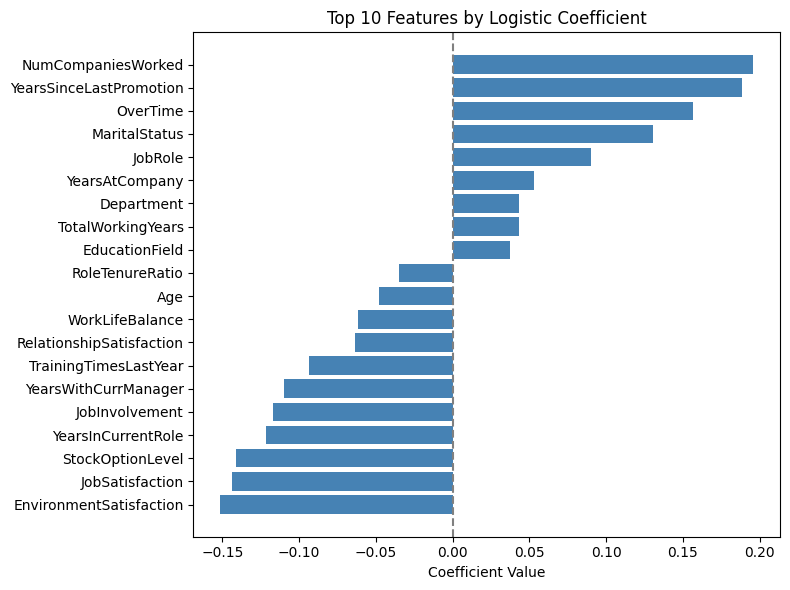

In [27]:
import matplotlib.pyplot as plt

# Plot top 10 features by absolute coefficient
top_n = 20
top_features = importance.head(top_n).sort_values(by="Coefficient")

plt.figure(figsize=(8, 6))
plt.barh(top_features["Feature"], top_features["Coefficient"], color="steelblue")
plt.axvline(0, color="gray", linestyle="--")
plt.title("Top 10 Features by Logistic Coefficient")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

We will now rerun the pipeline using just these 20 fields to see how that affects our ability to predict attrition.

In [28]:
# Already fitted logistic model on full X_encoded
importance = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Get top 20 feature names
top_20_features = importance["Feature"].head(20).tolist()

In [29]:
# Create reduced feature matrix
X_top20 = X_encoded[top_20_features]

In [32]:
from sklearn.metrics import precision_score, recall_score

# Predict and evaluate
y_pred = model_top20.predict(X_test)

# Precision and recall for the 'Yes' class
precision = precision_score(y_test, y_pred, pos_label="Yes")
recall = recall_score(y_test, y_pred, pos_label="Yes")

print(f"Precision (Yes): {precision:.3f}")
print(f"Recall (Yes):    {recall:.3f}")

Precision (Yes): 0.619
Recall (Yes):    0.333


While recall is improved over intial run, precision is slightly less. So next step, now we have our top 20 features, will be to add some synthetic data, to offset the issue of an imbalanced dataset and give the fit() more to work on.

In [ ]:
# Apply SMOTE to top 20 features

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_top20, y)

In [40]:
# Train-test split on balanced data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (1726, 20) (1726,)
Test shape: (740, 20) (740,)


In [43]:
# train on new enhanced data using BalancedRandomForest as it's better for enhanced imbalanced datasets

import warnings
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import precision_score, recall_score

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Initialize and fit model
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = brf_model.predict(X_test)
precision = precision_score(y_test, y_pred, pos_label="Yes")
recall = recall_score(y_test, y_pred, pos_label="Yes")

print(f"Balanced RF Precision (Yes): {precision:.3f}")
print(f"Balanced RF Recall (Yes):    {recall:.3f}")

Balanced RF Precision (Yes): 0.923
Balanced RF Recall (Yes):    0.900


Over 90% for both precision and recall is a significant improvement and so will be used as the model going forward.

In [44]:
# Save the pipeline to a file
joblib.dump(brf_model, "logistic_attrition_model.pkl")

['logistic_attrition_model.pkl']